In [98]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit
import time

In [2]:
dt = np.dtype([('counter', 'i4'), ('status', 'i4'), ('timestamp', 'f8'), ('micdata', '64i4')])


In [3]:
data = np.fromfile('mic_data/RawData_pureTX_Case1.dat',dtype=dt)
data = np.fromfile('mic_data/RawData_pureRX_330cm.dat',dtype=dt)
# data = np.fromfile('mic_data/RawData_pureTX_Case6.dat',dtype=dt)
# data = np.fromfile('mic_data/RawData_pureRX_330cm_Rev.dat',dtype=dt)


In [4]:
raw = np.zeros(64*len(data), dtype=np.int32)
for count in range(len(data)):
    raw[(count*64):((count+1)*64)] = data[count][3]

In [5]:
from goertzel_test import sg_z

generating ./_goertzel.c
(already up-to-date)
the current directory is '/Users/nams/Documents/projects/gburg-ultrasonic'
running build_ext
building '_goertzel' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/nams/micromamba/envs/cq/include -arch x86_64 -I/Users/nams/micromamba/envs/cq/include -arch x86_64 -I/Users/nams/micromamba/envs/cq/include/python3.8 -c _goertzel.c -o ./_goertzel.o
gcc -bundle -undefined dynamic_lookup -L/Users/nams/micromamba/envs/cq/lib -arch x86_64 -L/Users/nams/micromamba/envs/cq/lib -arch x86_64 -arch x86_64 ./_goertzel.o -lm -o ./_goertzel.cpython-38-darwin.so


In [ ]:
# Sliding Goertzel
@jit
def sg_v2(x, k, Z): #, C, S):
    Pxx =[]
    #Z = []
    N = 64*4
    w = 2*np.pi*k/N;
    cw = np.cos(w);
    c = 2*cw;
    sw = np.sin(w);
    z1=0;
    z2=0;
    #while (idx < (len(x)-1)):
    for idx in range(len(x)):
        if idx<N:
            z0 = x[idx] + c*z1 - z2;
        else:
            z0 = x[idx] - x[idx-N] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

        P = z2*z2 + z1*z1 - c * z1*z2
        I = cw*z1 -z2;
        Q = sw*z1;
        Pxx.append(P)
        #C[idx] = I
        #S[idx] = Q
        #Z.append(Q + 1j*I)
        Z[idx] = Q + 1j*I
    return np.array(Pxx)  #, np.array(C), np.array(S)


def sg(x, k):
    Z = np.zeros(len(x), complex)
    Pxx = sg_v2(x, k, Z)
    return Pxx, Z

In [ ]:
#Z = np.zeros(len(raw), complex)
#filtered = sg_v2(raw>>14, 100, Z)
filtered, Z = sg(raw>>14, 100)

Z = {}
Z2={}
f = {}
Z[100] = np.zeros(len(raw), complex)
f[100] = sg_v2(raw>>14, 100, Z[100])
Z[99] = np.zeros(len(raw), complex)
f[99] = sg_v2(raw>>14, 99, Z[99])
Z[101] = np.zeros(len(raw), complex)
f[101] = sg_v2(raw>>14, 101, Z[101])

for k in [99, 100, 101]:
    f[k], Z2[k] = sg(raw>>14, k)

hamming = abs(Z[100] * 2.0 - Z[99] - Z[101])
hamming2 =abs(Z2[100] * 2.0 - Z2[99] - Z2[101])

In [6]:
Z = {}
for k in range(98, 103):
    Z[k] = sg_z(raw>>14, k)

hamming = abs(Z[100] * 2.0 - Z[99] - Z[101])
y = abs(Z[100])

In [ ]:
np.where(hamming - hamming2)

In [ ]:
%matplotlib notebook
plt.figure()
plt.semilogy((2*filtered)**0.5)
plt.semilogy(hamming)

In [ ]:
y = (2*filtered)**0.5

In [7]:
from peak_mark import pk_mark

In [8]:
pks, s = pk_mark(y, 256, 2, 5e-4, 128, 300)
len(pks)

49

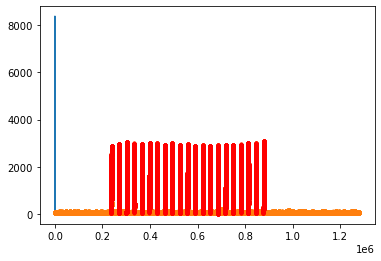

In [9]:
plt.figure()
t = np.arange(len(y))
plt.plot(t,y)
plt.plot(t[s==1], y[s==1],'.')
for pkinfo in pks:
    begin = int(pkinfo[0])
    end = int(pkinfo[0] + pkinfo[1])
    plt.plot(t[begin:end], y[begin:end], 'r.')

In [ ]:
np.diff(np.array(pks)[:,2])


In [20]:
pks

[[237147.0, 584.0, 237432.0, 1641.3169786964393],
 [237756.0, 514.0, 238010.0, 2891.337558654567],
 [269150.0, 582.0, 269441.0, 1745.8032251444806],
 [269765.0, 510.0, 270019.0, 2971.762439193229],
 [300673.0, 1051.0, 301443.0, 1679.6819192911341],
 [301762.0, 520.0, 302021.0, 3058.8331477897336],
 [333166.0, 558.0, 333443.0, 1772.1871694412068],
 [333762.0, 510.0, 334022.0, 2986.6108475296473],
 [334807.0, 139.0, 334881.0, 417.6974736474435],
 [365158.0, 566.0, 365442.0, 1858.2675687271824],
 [365771.0, 510.0, 366021.0, 2962.304767831505],
 [366753.0, 180.0, 366850.0, 451.18420705440906],
 [397168.0, 558.0, 397440.0, 1627.7352199097932],
 [397764.0, 511.0, 398018.0, 3025.067025503378],
 [398750.0, 137.0, 398832.0, 414.9266242239062],
 [429155.0, 466.0, 429445.0, 1778.407374432776],
 [429772.0, 501.0, 430018.0, 2995.280597919729],
 [461141.0, 566.0, 461444.0, 1810.3957305768029],
 [461768.0, 506.0, 462022.0, 2935.0173142844997],
 [493153.0, 550.0, 493441.0, 1859.6996666681905],
 [49376

In [ ]:
%matplotlib notebook
hamming = abs(hamming)
pks, s = pk_mark(hamming, 256, 4, 1e-3, 256, 300)
plt.figure()
t = np.arange(len(hamming))
plt.plot(t,hamming)
plt.plot(t[s==1], hamming[s==1],'.')
for pkinfo in pks:
    begin = int(pkinfo[0])
    end = int(pkinfo[0] + pkinfo[1])
    plt.plot(t[begin:end], hamming[begin:end], 'r.')
len(pks)

In [ ]:
np.diff(np.array(pks)[:,2])

In [ ]:
hamming = abs(hamming)
pks, s = pk_mark(hamming, 256, 3, 2.5e-4, 256, 300)
plt.figure()
t = np.arange(len(hamming))
plt.plot(t,hamming)
plt.plot(t[s==1], hamming[s==1],'.')
for pkinfo in pks:
    begin = int(pkinfo[0])
    end = int(pkinfo[0] + pkinfo[1])
    plt.plot(t[begin:end], hamming[begin:end], 'r.')

In [ ]:
len(pks)

In [ ]:
import glob


In [ ]:
files = glob.glob('mic_data/RawData_pureRX_*cm.dat')
files.sort()
files

In [ ]:
filtered = sg_v2(raw>>14, 100, Z)

In [ ]:
sig = []
for filename in files:
    data = np.fromfile(filename,dtype=dt)
    raw = np.zeros(64*len(data), dtype=np.int32)
    for count in range(len(data)):
        raw[(count*64):((count+1)*64)] = data[count][3]
    Z = np.zeros(len(raw), complex)
    filtered = sg_v2(raw>>14, 100, Z)

    Z = {}
    f = {}
    Z[100] = np.zeros(len(raw), complex)
    f[100] = sg_v2(raw>>14, 100, Z[100])
    Z[99] = np.zeros(len(raw), complex)
    f[99] = sg_v2(raw>>14, 99, Z[99])
    Z[101] = np.zeros(len(raw), complex)
    f[101] = sg_v2(raw>>14, 101, Z[101])

    hamming = abs(Z[100] * 2.0 - Z[99] - Z[101])
    
    pks, s = pk_mark(hamming, 256, 4, 1e-3, 256)
    print(filename)
    pks = np.array(pks)[:,3]
    print(pks.mean(), pks.std())
    sig.append([int(filename.split('_')[-1].split('cm')[0]), pks.mean()])

In [ ]:
sig

In [ ]:
sig.sort()

In [ ]:
sig = np.array(sig)

In [ ]:
plt.figure()
plt.plot(sig[:,0], sig[:,1],'x')
plt.axis([0, 500, 0, 30000])
x = np.arange(100, 500)
A = 4e8
y = A / x**2
plt.plot(x,y, label='eyeball fit to 1/r^2')
plt.legend()
plt.ylabel('filtered microphone peak size [hamming goertzel]')
plt.xlabel('distance [cm]')
plt.title('RawData_pureRX_*cm.dat')

In [ ]:
from cffi import FFI
ffi = FFI()
ffi.cdef("""
    typedef struct {
        int lag;
        int width;
        double threshold;
        double influence;
        double mph;
    } settings_t;
""")

In [ ]:
settings = ffi.new("settings_t *")
settings.lag = 256
settings.width = 128
settings.threshold = 2
settings.influence = 5e-4
settings.mph = 300

In [10]:
dt_settings = np.dtype([('lag', 'i4'), ('width', 'i4'), 
                        ('threshold', 'f8'), ('influence', 'f8'), ('mph', 'f8')
                       ])
settings_np = np.recarray(1, dtype=dt_settings)[0]

"""
lag -- integer of how many points to compute mean and std over
threshold -- double: multiples of std deviation that constitute a peak
influence -- double: amount signal in the peak influences the running avg and std
width -- integer:  minimum peak width to be added to the output
mph: double: minimum peak hieght
"""

In [11]:
settings_np.mph = 300
settings_np.lag = 256
settings_np.width = 128
settings_np.threshold = 2
settings_np.influence = 5e-4
settings_np

(256, 128, 2., 0.0005, 300.)

In [ ]:
@jit
def test(settings):
    print(settings)
    settings.mph = 301
    print(settings)
    

In [ ]:
test(settings_np)

In [12]:
dt_state = np.dtype([
                        ('avgFilter', 'f8'), ('std2', 'f8'),
                       ])
state_np = np.recarray(1, dtype=dt_state)[0]

In [13]:
state_np.avgFilter = 0
state_np.std2 = 0
state_np

(0., 0.)

In [14]:
import numpy as np
from numba import jit

@jit
def peak_marking_v3(y, yLen, filteredY, settings, state, signals): #, filteredY):
    lag = settings.lag

    avgFilter = state.avgFilter
    std2 = state.std2
    stdFilter = state.std2**0.5
    pks = []
    start, length, pk, pk_idx = -1, 0, -1, -1
    write_addr = -1
    time_between = -1

    for i in range(yLen):
        # if i == lag:
        #     print(avgFilter, stdFilter)
        write_addr += 1
        time_between += 1
        
        idx = write_addr % lag
        prev_idx = (write_addr -1 + lag) % lag
        
        oldValue = filteredY[idx] # store this for use to update mean and std
        if abs(y[i] - avgFilter) > settings.threshold * stdFilter and (i>=lag):
            if (y[i] > avgFilter):
                signals[i] = 1
                if start<0:
                    start, length = i, 1
                    #print(start)
                else:
                    #print(i, start, length)
                    length += 1
                if y[i]>pk:
                    pk, pk_idx = y[i], i
                    pk_time = time_between
            else:
                signals[i] = -1
                if (start>0) and (length>settings.width) and (pk>settings.mph):
                    pks.append([start, length, pk_idx, pk, pk_time])
                    # print("-1", i, start, length, pk_idx, pk)
                    start, length, pk, pk_idx = -1, 0, -1, -1
                    time_between = time_between - pk_time
            filteredY[idx] = settings.influence * y[i] + (1 - settings.influence) * filteredY[prev_idx]
        else:
            signals[i] = 0
            filteredY[idx] = y[i]
            if (start>0) and (length>settings.width) and (pk>settings.mph):
                pks.append([start, length, pk_idx, pk, pk_time])
                # print("0:", i, start, length, pk, pk_idx)
                time_between = time_between - pk_time 
            start, length, pk, pk_idx = -1, 0, -1, -1
        prevAvg = avgFilter
        avgFilter = avgFilter + (filteredY[idx] - oldValue) / lag
        #print(prevAvg, avgFilter, filteredY[i%lag], oldValue)
        # avgFilter = np.mean(filteredY)
        std2 = std2 + (filteredY[idx] - oldValue)*(filteredY[idx] + oldValue - avgFilter - prevAvg) /lag
        stdFilter = std2**0.5
        #stdFilter = np.std(filteredY)
    state.std2 = std2
    state.avgFilter = avgFilter
    return pks

@jit
def pk_mark_v3(y, settings, state):
    """Find and mark peaks using z-scor algorithm
    
    Returns:  pks, signals
    pks -- list of peaks... [start, length, pk_idx, pk]
    signals -- numpy array that is the length of the input.  
            1 if in + peak, -1 in - peak, 0 not in peak
            
    Keyword arguments:
    y -- numpy array of input signal
    lag -- integer of how many points to compute mean and std over
    threshold -- double: multiples of std deviation that constitute a peak
    influence -- double: amount signal in the peak influences the running avg and std
    width -- integer:  minimum peak width to be added to the output
    mph: double: minimum peak hieght
    """
    signals = np.zeros(len(y))
    filteredY = np.zeros(settings.lag)
    pks = peak_marking_v3(y, len(y), filteredY, settings, state, signals)
    print(state)
    return pks, signals


In [15]:
#s3 = np.zeros(len(y))
#pks3 = peak_marking_v3(y, settings_np, s3)
dt_state = np.dtype([
                    ('avgFilter', 'f8'), ('std2', 'f8'),
                   ])
state = np.recarray(1, dtype=dt_state)[0]
state.avgFilter = 0
state.std2 = 0
pks3, s3 = pk_mark_v3(y, settings_np, state)
len(pks3)

(40.3291016, 0.69078655)


49

In [16]:
len(pks3),pks3
np.array(pks3)[:,:4] - np.array(pks)
# np.diff(np.array(pks3)[:,2]) - np.array(pks3)[1:,4]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


In [107]:
import numpy as np
from numba import jit

@jit
def peak_marking_block(y, yLen, filteredY, settings, state, signals): #, filteredY):
    lag = settings.lag

    avgFilter = state.avgFilter
    std2 = state.std2
    stdFilter = state.std2**0.5
    pks = []
    # start, length, pk, pk_idx = -1, 0, -1, -1
    write_addr = state.write_addr
    time_between = state.time_between
    length = state.length
    pk = state.pk
    pk_idx = state.pk_idx
    pk_time = state.pk_time
    #print(write_addr, length, pk, pk_idx)
    for i in range(yLen):
        # if (i%64) == 0:
        #    print(avgFilter, stdFilter)
        write_addr += 1
        time_between += 1
        
        idx = write_addr % lag
        prev_idx = (write_addr -1 + lag) % lag
        
        oldValue = filteredY[idx] # store this for use to update mean and std

        if abs(y[i] - avgFilter) > settings.threshold * stdFilter and (write_addr>=lag):
            if (y[i] > avgFilter):
                signals[i] = 1
                #if start<0:
                if length==0:
                    start, length = i, 1
                    #print(start)
                else:
                    #print(i, start, length)
                    length += 1
                if y[i]>pk:
                    pk, pk_idx = y[i], i
                    pk_time = time_between
            else:
                signals[i] = -1
                if (length>0) and (length>settings.width) and (pk>settings.mph):
                    # pks.append([start, length, pk_idx, pk, pk_time])
                    pks.append([pk_time, length, pk])
                    print("-1", i, start, length, pk_idx, pk)
                    start, length, pk, pk_idx = -1, 0, -1, -1
                    time_between = time_between - pk_time
            filteredY[idx] = settings.influence * y[i] + (1 - settings.influence) * filteredY[prev_idx]
        else:
            signals[i] = 0
            filteredY[idx] = y[i]
            if (length>0) and (length>settings.width) and (pk>settings.mph):
                #pks.append([start, length, pk_idx, pk, pk_time])
                pks.append([pk_time, length, pk])
                #print("0:", i, start, length, pk, pk_idx, time_between, pk_time)
                time_between = time_between - pk_time 
            start, length, pk, pk_idx = -1, 0, -1, -1
        prevAvg = avgFilter
        avgFilter = avgFilter + (filteredY[idx] - oldValue) / lag
        #print(prevAvg, avgFilter, filteredY[i%lag], oldValue)
        # avgFilter = np.mean(filteredY)
        std2 = std2 + (filteredY[idx] - oldValue)*(filteredY[idx] + oldValue - avgFilter - prevAvg) /lag
        stdFilter = std2**0.5
        #stdFilter = np.std(filteredY)
    state.std2 = std2
    state.avgFilter = avgFilter
    state.write_addr = write_addr
    state.time_between = time_between
    state.length = length
    state.pk = pk
    state.pk_idx = pk_idx
    state.pk_time = pk_time

    return pks

@jit
def pk_mark_block(y, settings, state):
    """Find and mark peaks using z-scor algorithm
    
    Returns:  pks, signals
    pks -- list of peaks... [start, length, pk_idx, pk]
    signals -- numpy array that is the length of the input.  
            1 if in + peak, -1 in - peak, 0 not in peak
            
    Keyword arguments:
    y -- numpy array of input signal
    settings -- numpy record structure with parameters for identifying peaks
    state -- numpy record structure that stores the state of peak finding between blocks of data
    """
    signals = np.zeros(len(y))
    filteredY = np.zeros(settings.lag)
    pks = peak_marking_block(y, len(y), filteredY, settings, state, signals)
    print(state)
    return pks, signals


In [117]:
dt_settings = np.dtype([('lag', 'i4'), ('width', 'i4'), 
                        ('threshold', 'f8'), ('influence', 'f8'), ('mph', 'f8')
                       ])
settings_np = np.recarray(1, dtype=dt_settings)[0]

settings_np.mph = 300
settings_np.lag = 256
settings_np.width = 128
settings_np.threshold = 3
settings_np.influence = 5e-4
print('settings', settings_np)

dt_state = np.dtype([
                    ('avgFilter', 'f8'), ('std2', 'f8'),
                    ('write_addr', 'i4'), ('time_between', 'i4'),
                    ('length', 'i4'), ('pk_idx', 'i4'),
                    ('pk', 'f8'),
                    ('pk_time', 'i4'),
                   ])
state = np.recarray(1, dtype=dt_state)[0]
state.avgFilter = 0
state.std2 = 0
state.write_addr = -1
state.length = 0
state.pk_idx = -1
state.pk = -1
state.time_between = -1
state.pk_time = -1

start = time.time()
pks_b, s_b = pk_mark_block(y, settings_np, state)
print(time.time()-start)
len(pks_b), len(y)

settings (256, 128, 3., 0.0005, 300.)
(51.79013509, 256.09011604, 1279999, 401983, 0, -1, -1., 401717)
0.050447940826416016


(42, 1280000)

In [ ]:
len(pks_b),pks_b
np.array(pks_b) - np.array(pks3)
# np.diff(np.array(pks3)[:,2]) - np.array(pks3)[1:,4]

In [ ]:
plt.figure()
plt.plot(d_b)

In [ ]:
s_b.ctypes.data == s.ctypes.data, (s3!=s).sum()

In [121]:
dt_settings = np.dtype([('lag', 'i4'), ('width', 'i4'), 
                        ('threshold', 'f8'), ('influence', 'f8'), ('mph', 'f8')
                       ])
settings_np = np.recarray(1, dtype=dt_settings)[0]

settings_np.mph = 300
settings_np.lag = 256
settings_np.width = 128
settings_np.threshold = 3
settings_np.influence = 5e-4
print('settings', settings_np)

dt_state = np.dtype([
                    ('avgFilter', 'f8'), ('std2', 'f8'),
                    ('write_addr', 'i4'), ('time_between', 'i4'),
                    ('length', 'i4'), ('pk_idx', 'i4'),
                    ('pk', 'f8'),
                    ('pk_time', 'i4'),
                   ])
state = np.recarray(1, dtype=dt_state)[0]
state.avgFilter = 0
state.std2 = 0
state.write_addr = -1
state.length = 0
state.pk_idx = -1
state.pk = -1
state.time_between = -1
state.pk_time = -1
settings = settings_np

pks_blocks = []
signals = np.zeros(len(y))
debug = np.zeros(len(y))
filteredY = np.zeros(settings.lag)
start = time.time()
for count in range(len(y)//64):
#for count in range(4000):
    packet = y[(count*64):((count+1)*64)]
    packet_s = signals[(count*64):((count+1)*64)]
    # packet_d = debug[(count*64):((count+1)*64)]
    result = peak_marking_block(packet, len(packet), filteredY, settings, state, packet_s)
    if result:
        pks_blocks.extend(result)
print(time.time()-start)
print(state)
len(pks_b), len(y)

settings (256, 128, 3., 0.0005, 300.)
0.30461812019348145
(51.79013509, 256.09011604, 1279999, 401983, 0, -1, -1., 401717)


(42, 1280000)